In [1]:
import sys
import logging
import dbclients
import scgenome.utils

from scgenome.loaders.qc import load_cached_qc_data
from scgenome.db.qc import cache_qc_results
from scgenome.analyses.infer_clones import load_cell_cycle_data

LOGGING_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(format=LOGGING_FORMAT, stream=sys.stderr, level=logging.INFO)

tantalus_api = dbclients.tantalus.TantalusApi()

hmmcopy_tickets = [
#     'SC-1935',
    'SC-1936',
#     'SC-1937',
]

sample_ids = [
#     'SA922',
    'SA921',
#     'SA1090',
]

local_cache_directory = '/Users/mcphera1/Scratch/tantalus_data/'

cn_data = []
segs_data = []
metrics_data = []
align_metrics_data = []

for jira_ticket in hmmcopy_tickets:
    analysis = tantalus_api.get(
        'analysis',
        analysis_type__name='hmmcopy',
        jira_ticket=jira_ticket)

    cache_qc_results(jira_ticket, local_cache_directory)
    hmmcopy_data = load_cached_qc_data(jira_ticket, local_cache_directory, sample_ids=sample_ids)

    cn_data.append(hmmcopy_data['hmmcopy_reads'])
    segs_data.append(hmmcopy_data['hmmcopy_segs'])
    metrics_data.append(hmmcopy_data['hmmcopy_metrics'])
    align_metrics_data.append(hmmcopy_data['align_metrics'])

cn_data = scgenome.utils.concat_with_categories(cn_data)
segs_data = scgenome.utils.concat_with_categories(segs_data)
metrics_data = scgenome.utils.concat_with_categories(metrics_data)
align_metrics_data = scgenome.utils.concat_with_categories(align_metrics_data)

if 'is_s_phase' not in metrics_data:
    cell_cycle_data = load_cell_cycle_data(
        tantalus_api,
        analysis['jira_ticket'])
    cell_cycle_data['cell_id'] = cell_cycle_data['cell_id'].astype('category')

    scgenome.utils.union_categories([
        cn_data,
        metrics_data,
        align_metrics_data,
        cell_cycle_data])

    metrics_data = metrics_data.merge(cell_cycle_data, how='left')
    assert 'cell_id_x' not in metrics_data


2019-08-13 22:12:15,157 - INFO - 15c3f5d8-85e3-4629-860c-42297206ccb8 - TokenRequest:Getting token with client credentials.
2019-08-13 22:12:15,361 - INFO - 15c3f5d8-85e3-4629-860c-42297206ccb8 - OAuth2Client:Get Token Server returned this correlation_id: 15c3f5d8-85e3-4629-860c-42297206ccb8
2019-08-13 22:12:16,191 - INFO - skipping caching of SC-1936/results/results/alignment/plots/A90554A_plot_metrics.pdf
2019-08-13 22:12:16,192 - INFO - skipping caching of SC-1936/results/results/alignment/A90554A_alignment_metrics.h5
2019-08-13 22:12:16,193 - INFO - skipping caching of SC-1936/results/results/alignment/info.yaml
2019-08-13 22:12:16,193 - INFO - skipping caching of SC-1936/results/results/alignment/A90554A_gc_metrics.csv.gz
2019-08-13 22:12:16,194 - INFO - skipping caching of SC-1936/results/results/alignment/A90554A_gc_metrics.csv.gz.yaml
2019-08-13 22:12:16,195 - INFO - starting caching SC-1936/results/results/alignment/A90554A_alignment_metrics.csv.gz to /Users/mcphera1/Scratch/t

(628, 43)
(337, 1)


/Users/mcphera1/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)
2019-08-13 22:12:54,048 - INFO - matrix with size (4, 6206)
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:150: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


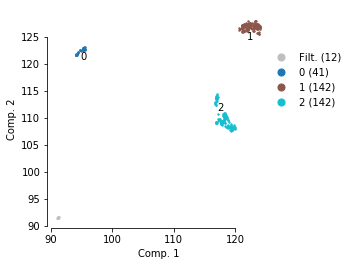

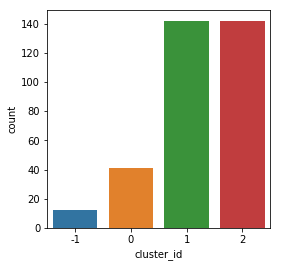

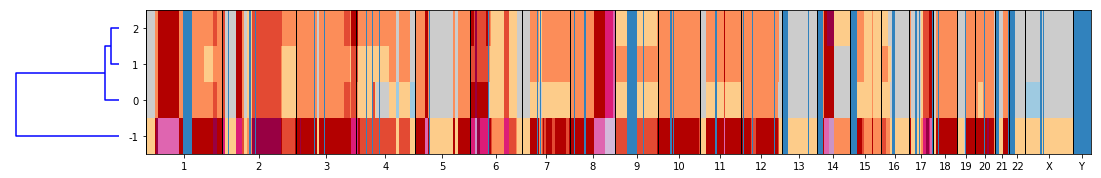

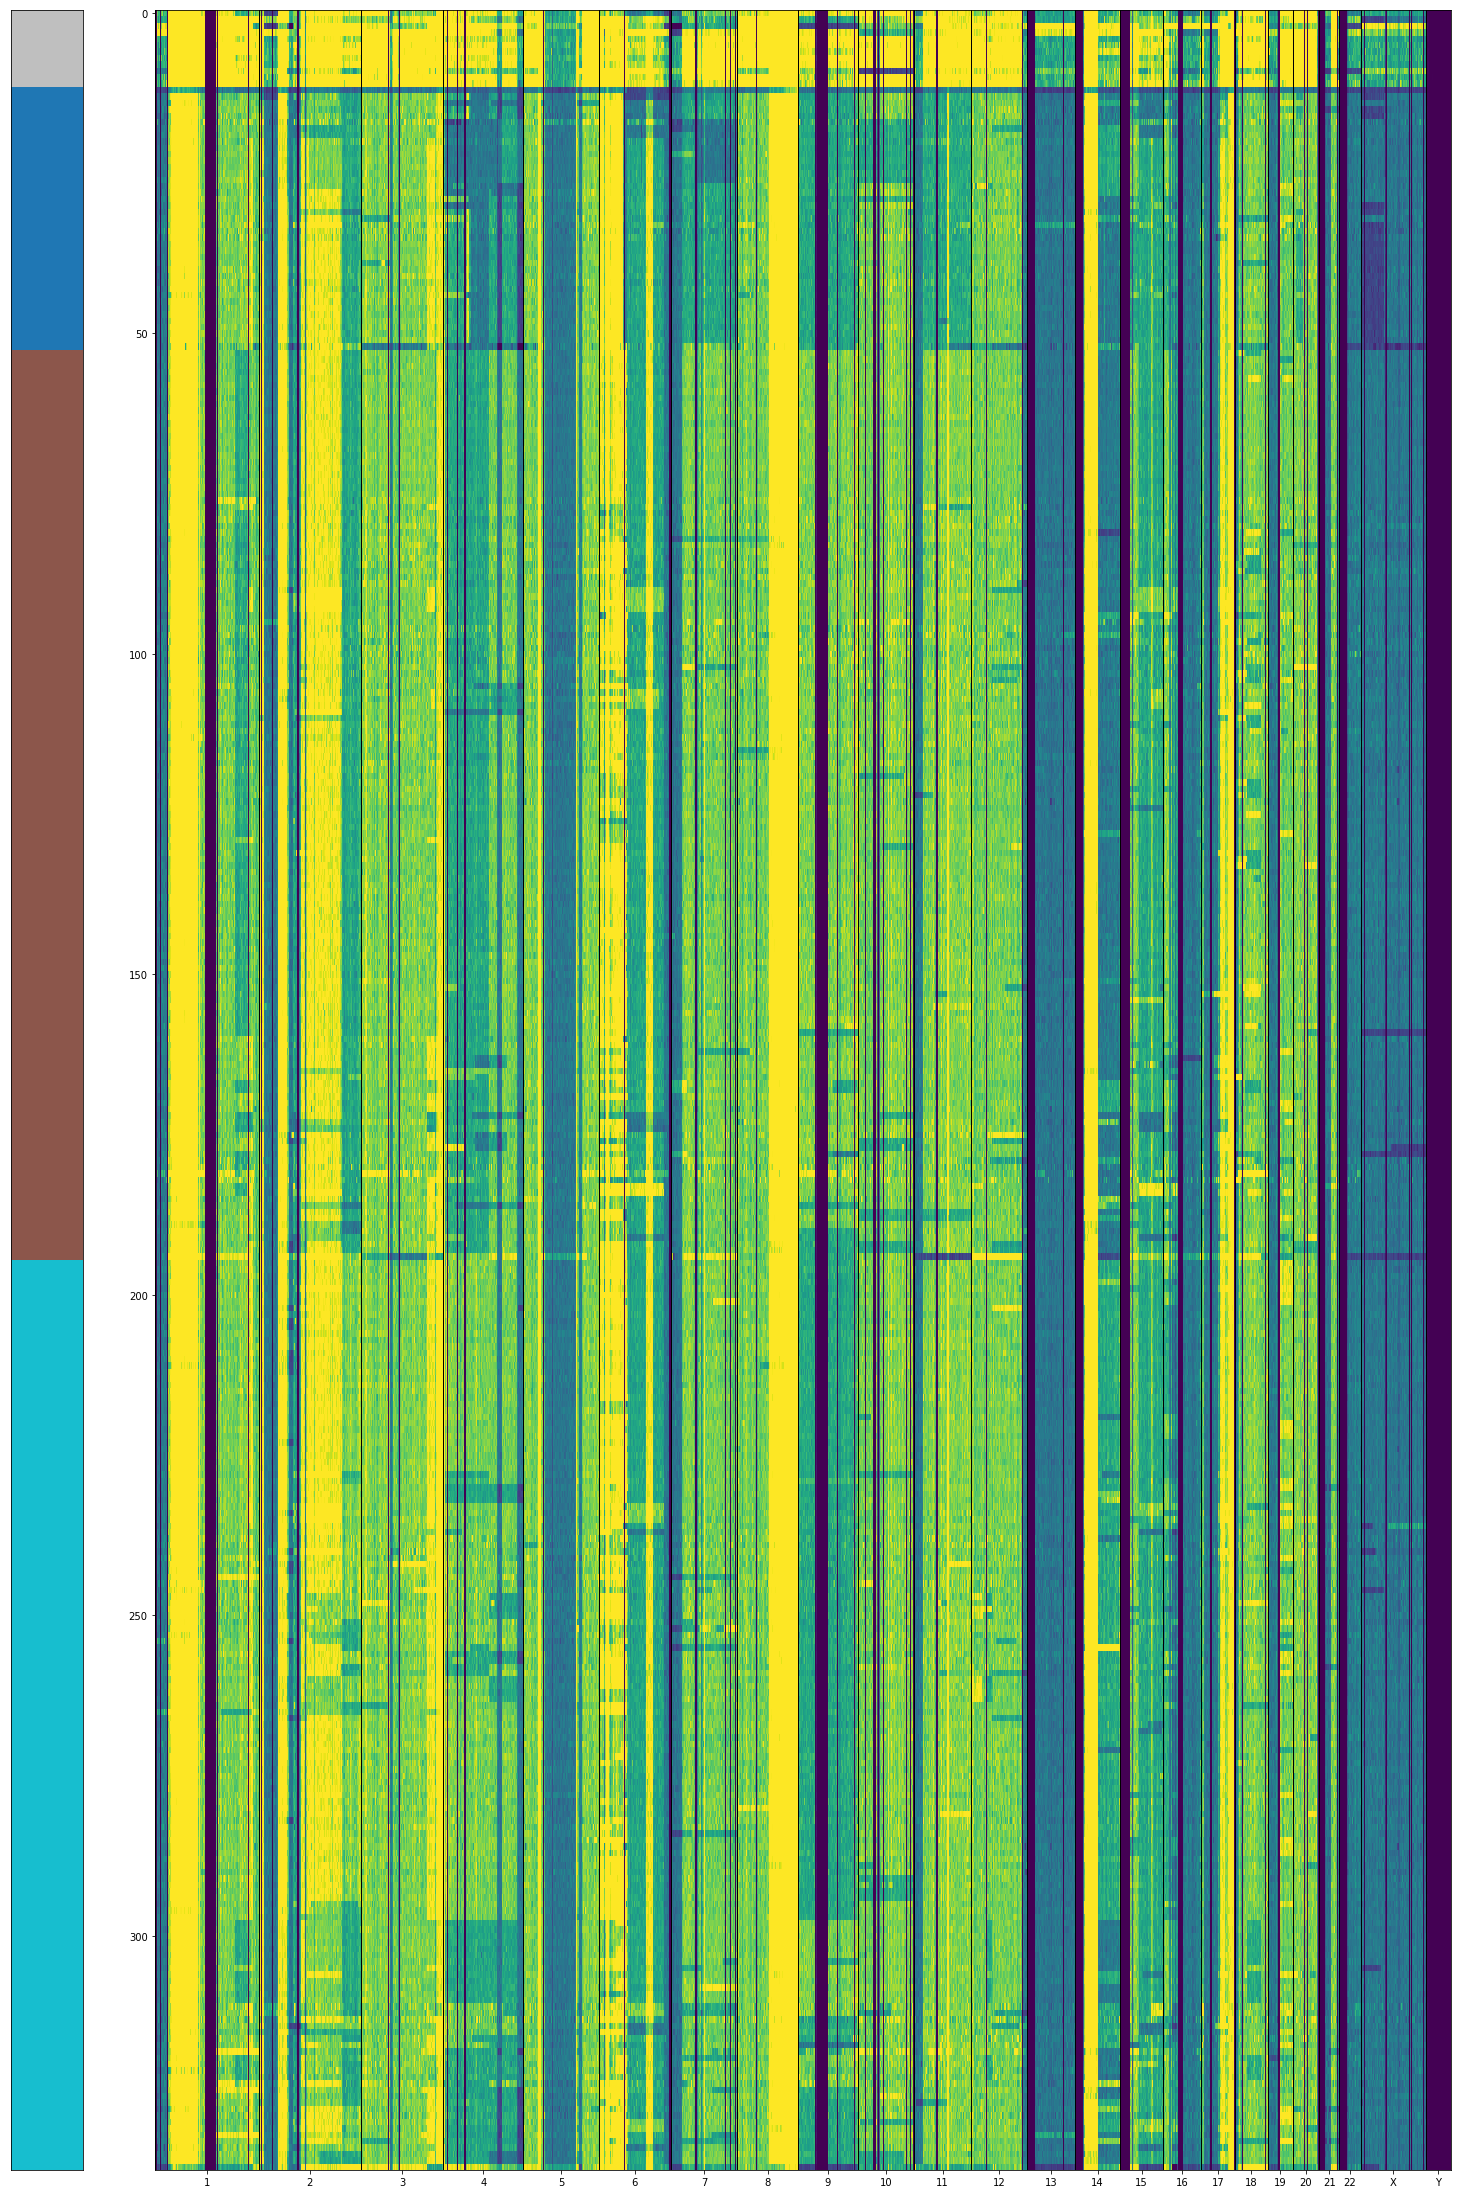

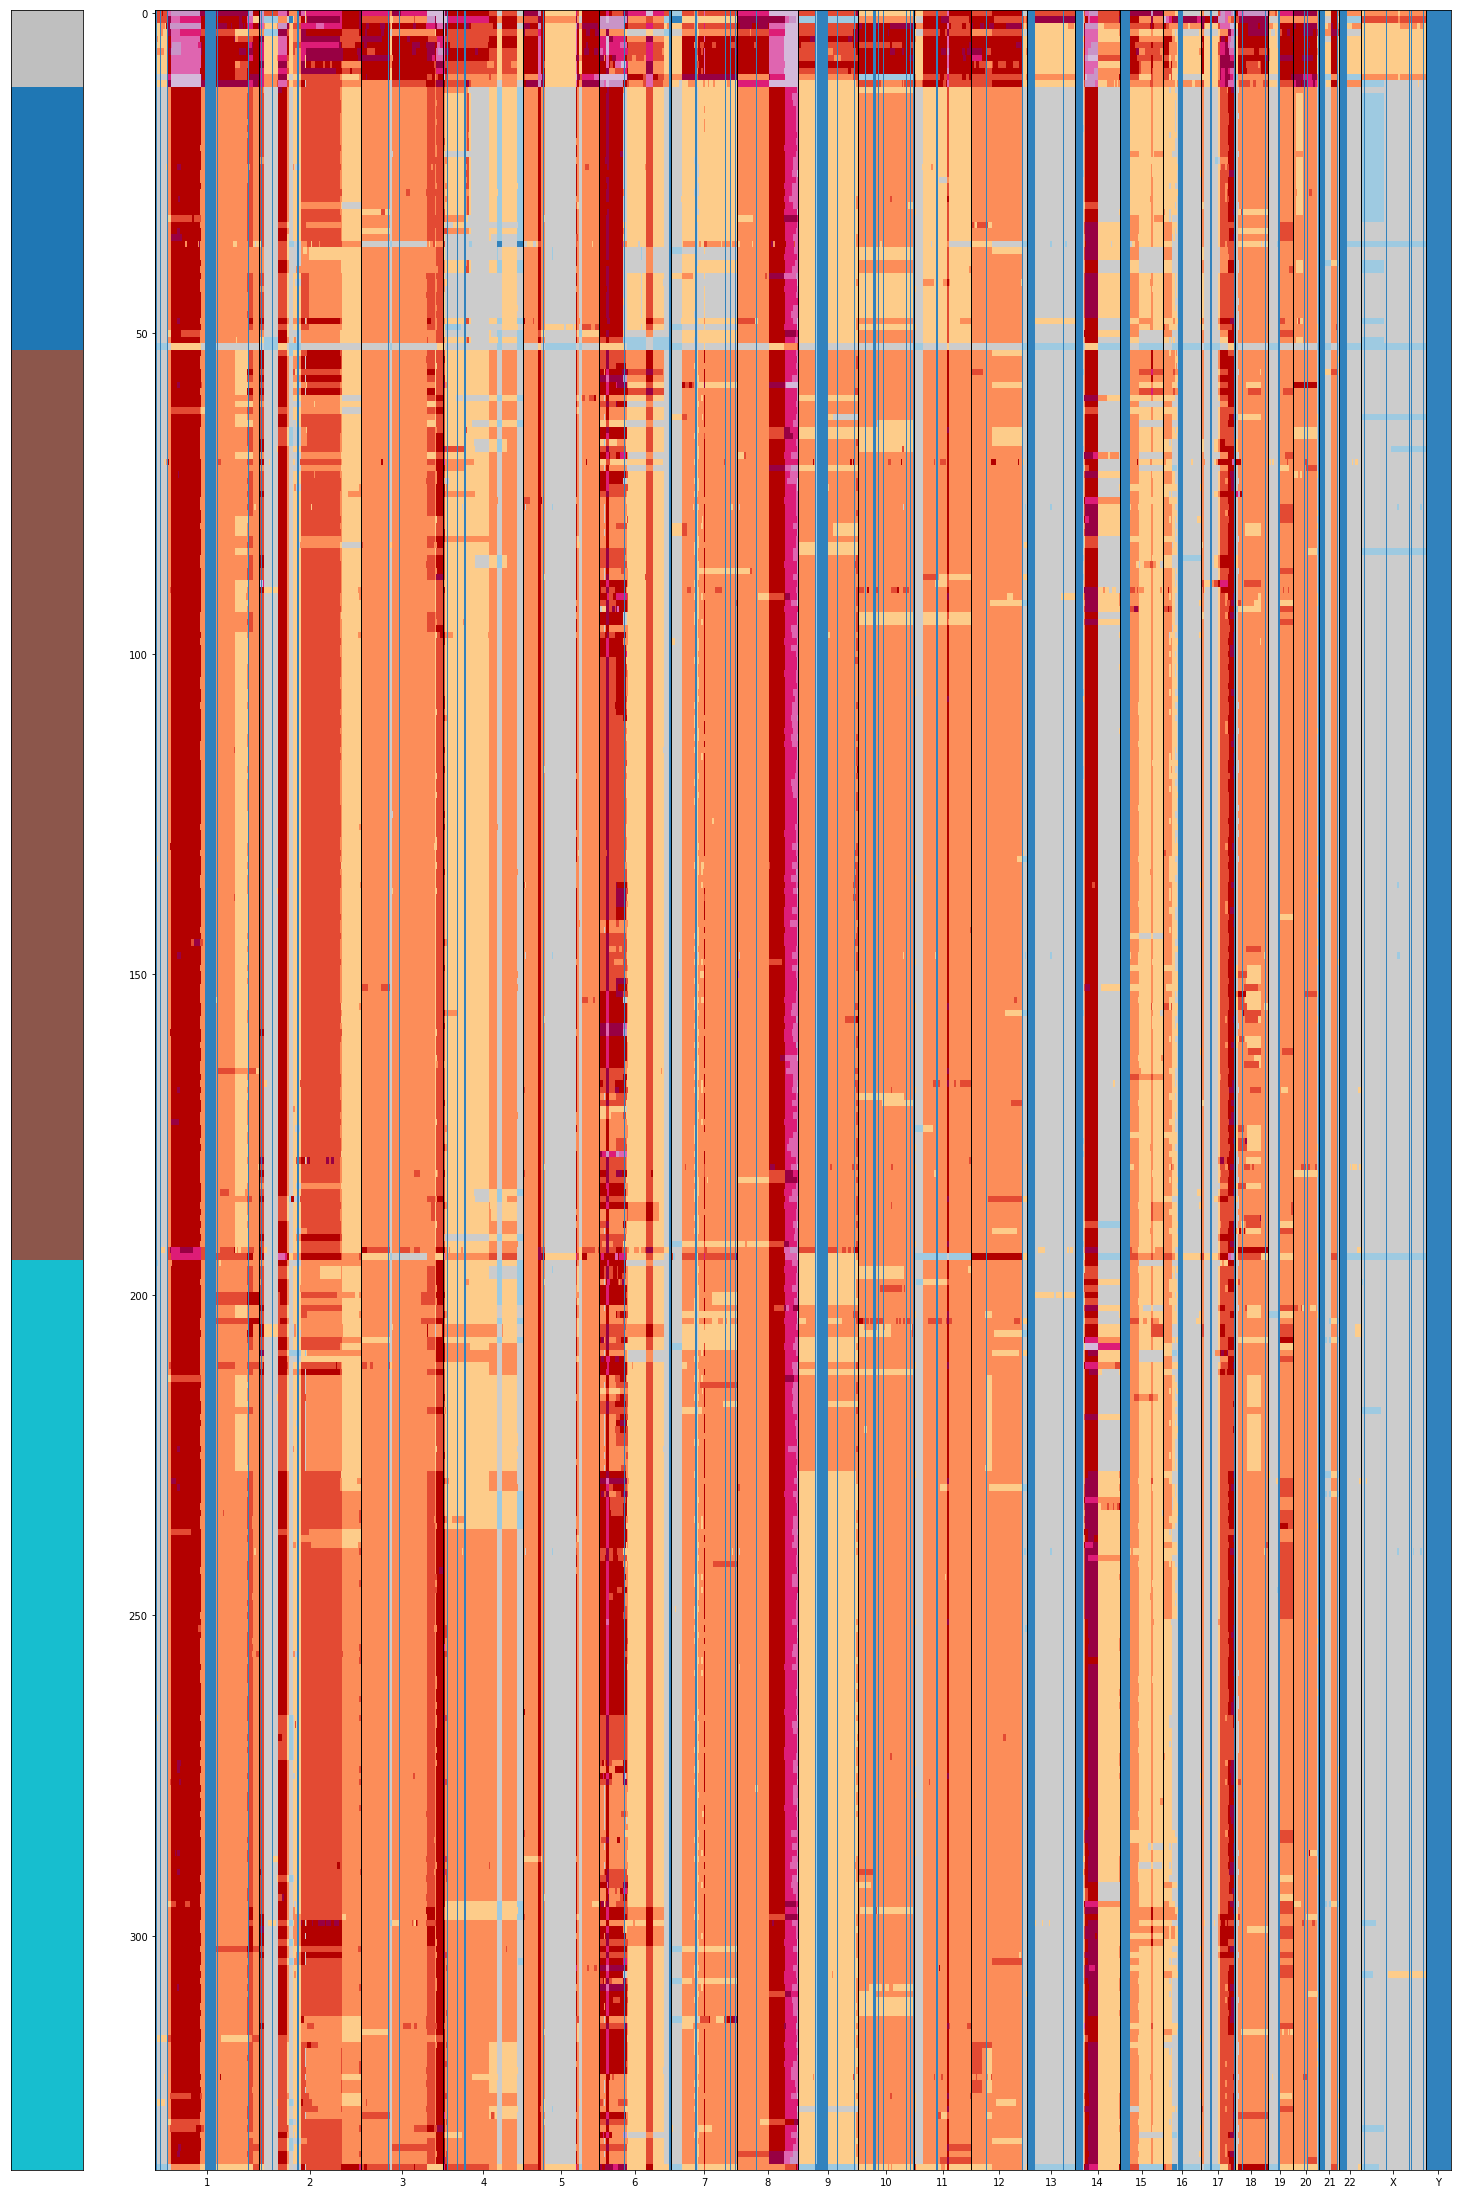

In [2]:

import scgenome.cncluster
import scgenome.cnplot
import matplotlib.pyplot as plt
import scipy.stats
import seaborn
import numpy as np
import pandas as pd


def calc_prop_hom_del(states):
    cndist = states.value_counts()
    cndist = cndist / cndist.sum()
    if 0 not in cndist:
        return 0
    return cndist[0]

metrics_data['filter_quality'] = (metrics_data['quality'] > 0.75)
metrics_data['filter_reads'] = (metrics_data['total_mapped_reads_hmmcopy'] > 500000)
print(metrics_data.shape)

# Calculate proportion homozygous deletion state
prop_hom_del = cn_data.groupby('cell_id')['state'].apply(calc_prop_hom_del).rename('prop_hom_del').reset_index()
metrics_data = metrics_data.merge(prop_hom_del, how='left')
metrics_data['prop_hom_del'] = metrics_data['prop_hom_del'].fillna(0)
metrics_data['zscore_prop_hom_del'] = scipy.stats.zscore(metrics_data['prop_hom_del'])
metrics_data['filter_prop_hom_del'] = (metrics_data['zscore_prop_hom_del'] < 3.)

# Calculate separation between predicted and normalized copy number
copy_state_diff = cn_data[['cell_id', 'copy', 'state']].copy()
copy_state_diff['copy_state_diff'] = np.absolute(copy_state_diff['copy'] - copy_state_diff['state'])
copy_state_diff = (copy_state_diff[['cell_id', 'copy_state_diff']]
    .dropna().groupby('cell_id')['copy_state_diff']
    .mean().reset_index().dropna())
metrics_data = metrics_data.merge(copy_state_diff)
metrics_data['filter_copy_state_diff'] = (metrics_data['copy_state_diff'] < 1.)

# Remove s phase cells
# Remove low quality cells
# Remove low coverage cells
# Remove cells with a large divergence between copy state and norm copy number
# Remove cells with outlier proportion of homozygous deletion
filtered_cells = metrics_data.loc[
    (~metrics_data['is_s_phase']) &
    metrics_data['filter_quality'] &
    metrics_data['filter_reads'] &
    metrics_data['filter_copy_state_diff'] &
    metrics_data['filter_prop_hom_del'],
    ['cell_id']]

print(filtered_cells.shape)

cn_data = cn_data.merge(filtered_cells[['cell_id']].drop_duplicates())
assert isinstance(cn_data['cell_id'].dtype, pd.api.types.CategoricalDtype)

cn = (
    cn_data
        .set_index(['chr', 'start', 'end', 'cell_id'])['copy']
        .unstack(level='cell_id').fillna(0)
)

clusters = scgenome.cncluster.umap_hdbscan_cluster(cn)

fig = plt.figure(figsize=(4, 4))
scgenome.cncluster.plot_umap_clusters(plt.gca(), clusters)

fig = plt.figure(figsize=(4, 4))
seaborn.barplot(x='cluster_id', y='count', data=clusters.groupby('cluster_id').size().rename('count').reset_index())

cn_data = cn_data.merge(clusters[['cell_id', 'cluster_id']].drop_duplicates())

plot_data = cn_data.copy()
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[bin_filter, 'state'] = 0
plot_data.loc[plot_data['copy'] > 5, 'copy'] = 5.
plot_data.loc[plot_data['copy'] < 0, 'copy'] = 0.

cluster_col = 'cluster_id'

fig = plt.figure(figsize=(15, 2))
scgenome.cnplot.plot_cluster_cn_matrix(
    fig, plot_data, 'state', cluster_field_name=cluster_col)

fig = plt.figure(figsize=(20, 30))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'copy', cluster_field_name=cluster_col, raw=True)

fig = plt.figure(figsize=(20, 30))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'state', cluster_field_name=cluster_col)


In [10]:

from scgenome.jointcnmodels import calculate_ll_normal_simple
from remixt.bpmodel import max_product


import scipy.stats
import scipy
from remixt.bpmodel import sum_product


from scgenome.jointcnmodels import calculate_marginal_ll_simple
from scgenome.jointcnmodels import gibbs_sample_cluster_indices

matrix_data = (
    cn_data.set_index(['chr', 'start', 'cell_id'])
    [['reads', 'state', 'copy']]
    .unstack(level=2, fill_value=0.))

cn = matrix_data['state'].astype(int).values
reads = matrix_data['reads'].values
hmmcopy_cn = matrix_data['state'].values
copy = matrix_data['copy'].values

measurement = copy.T

n_segments = measurement.shape[1]
n_states = 8
n_cells = measurement.shape[0]

cell_state_var = cn_data[['cell_id', 'state', 'copy']].dropna().groupby(['cell_id', 'state'])['copy'].var().rename('copy_var').reset_index()
#cell_state_var = cell_state_var.merge(cn_data[['cell_id', 'measurement']].drop_duplicates())

variances = cell_state_var.set_index(['state', 'cell_id'])['copy_var'].unstack()
variances = variances.reindex(columns=matrix_data['reads'].columns, index=range(n_states)).fillna(0.05).T
variances = variances.values

variances[variances < 0.001] = 0.001

print(variances.shape)

tr_probs = np.zeros((n_segments, n_states, n_states))
tr_probs[:] += 1.
tr_probs[:, range(n_states), range(n_states)] += 100.
tr_probs /= tr_probs.sum(axis=2)[:, :, np.newaxis]
tr_mat = np.log(tr_probs)

print(calculate_marginal_ll_simple(measurement, variances, tr_mat))

# variances = np.ones((n_cells, n_states)) * 0.25

assignments = np.zeros((n_cells,), dtype=int)

alpha = 0.001
max_clusters = 10

for i in range(10):
    print(i)
    assignments = gibbs_sample_cluster_indices(measurement, variances, tr_mat, assignments, max_clusters, alpha)



(337, 8)
-3215888.5792644387
0
1
2
3
4
5
6
7
8
9


/Users/mcphera1/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


,cell_id,cluster_id,umap1,umap2
0,SA921-A90554A-R05-C57,9,118.292450,110.881569
1,SA921-A90554A-R11-C16,4,95.234764,122.829361
2,SA921-A90554A-R08-C52,6,122.925827,126.653656
3,SA921-A90554A-R08-C51,3,124.102325,127.025475
4,SA921-A90554A-R11-C11,6,123.297935,126.923950


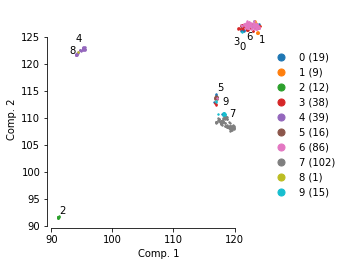

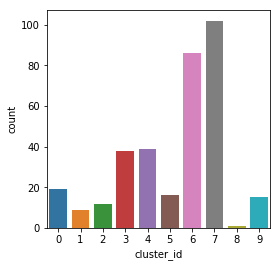

In [39]:

gibbs_clusters = pd.DataFrame({'gibbs_cluster_id': assignments}, index=matrix_data['copy'].columns).reset_index()

gibbs_clusters = gibbs_clusters.merge(clusters).drop(['cluster_id'], axis=1).rename(columns={'gibbs_cluster_id': 'cluster_id'})

fig = plt.figure(figsize=(4, 4))
scgenome.cncluster.plot_umap_clusters(plt.gca(), gibbs_clusters)

fig = plt.figure(figsize=(4, 4))
seaborn.barplot(x='cluster_id', y='count', data=gibbs_clusters.groupby('cluster_id').size().rename('count').reset_index())

gibbs_clusters.head()


2019-08-14 12:04:43,673 - INFO - matrix with size (10, 6206)
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:150: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')
/Users/mcphera1/Projects/scgenome/scgenome/cnplot.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method='complete')


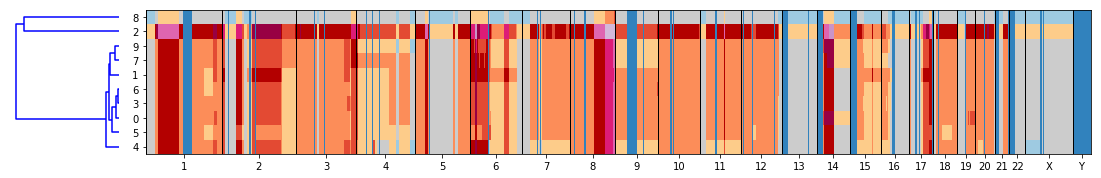

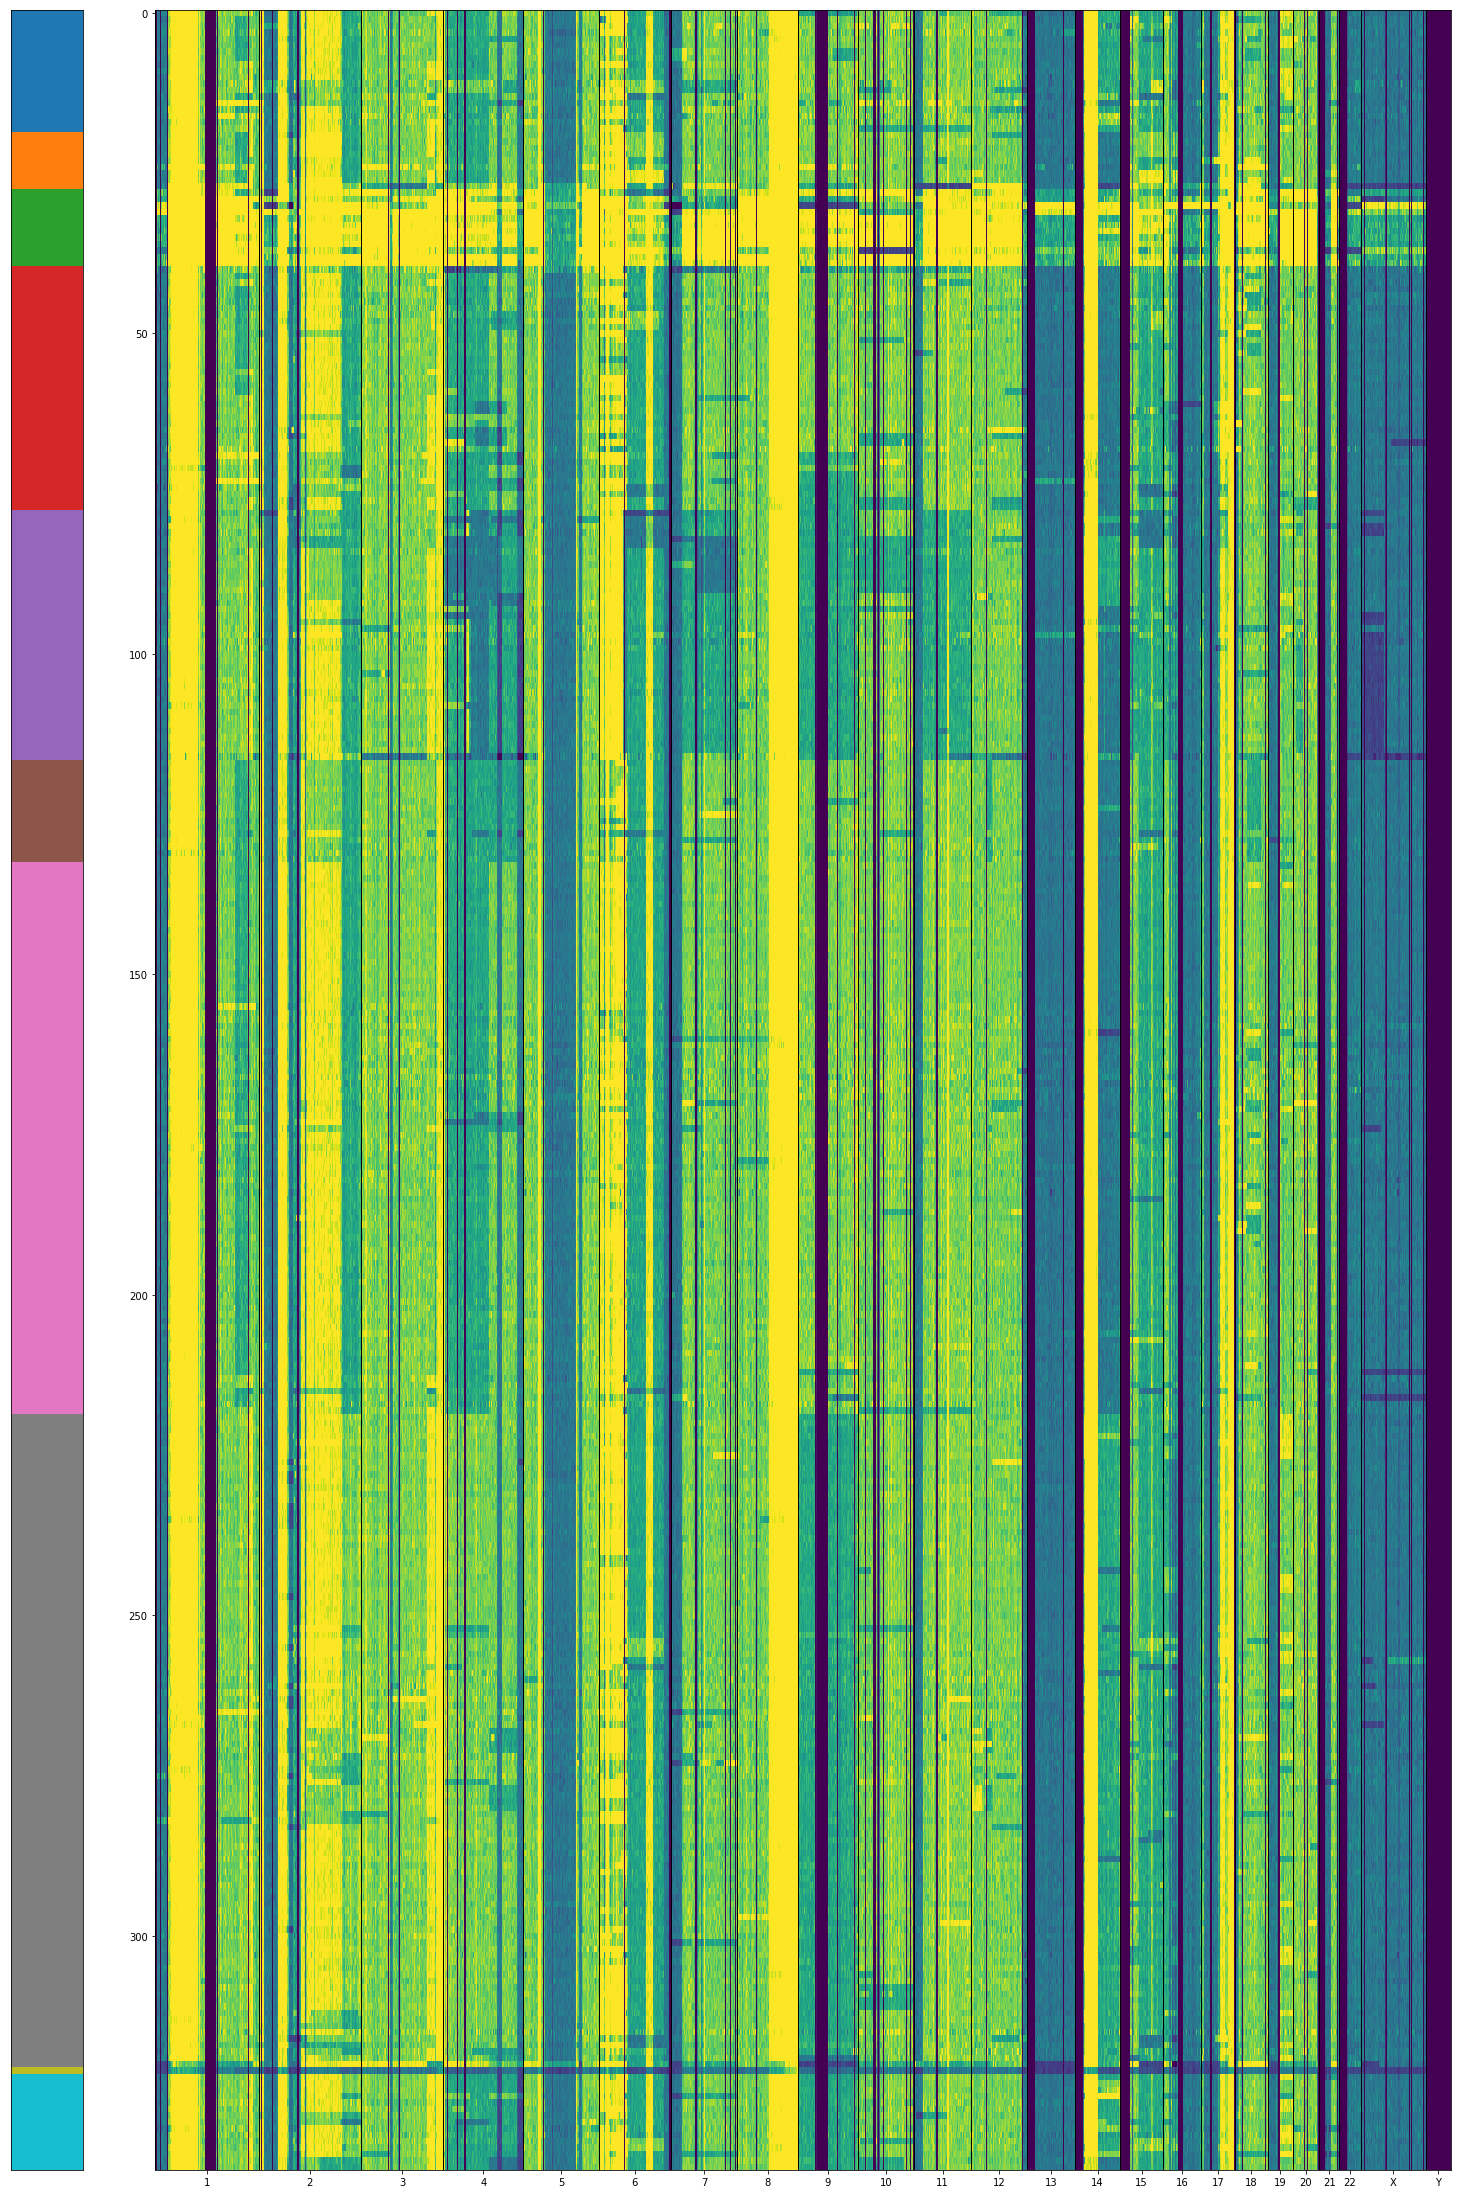

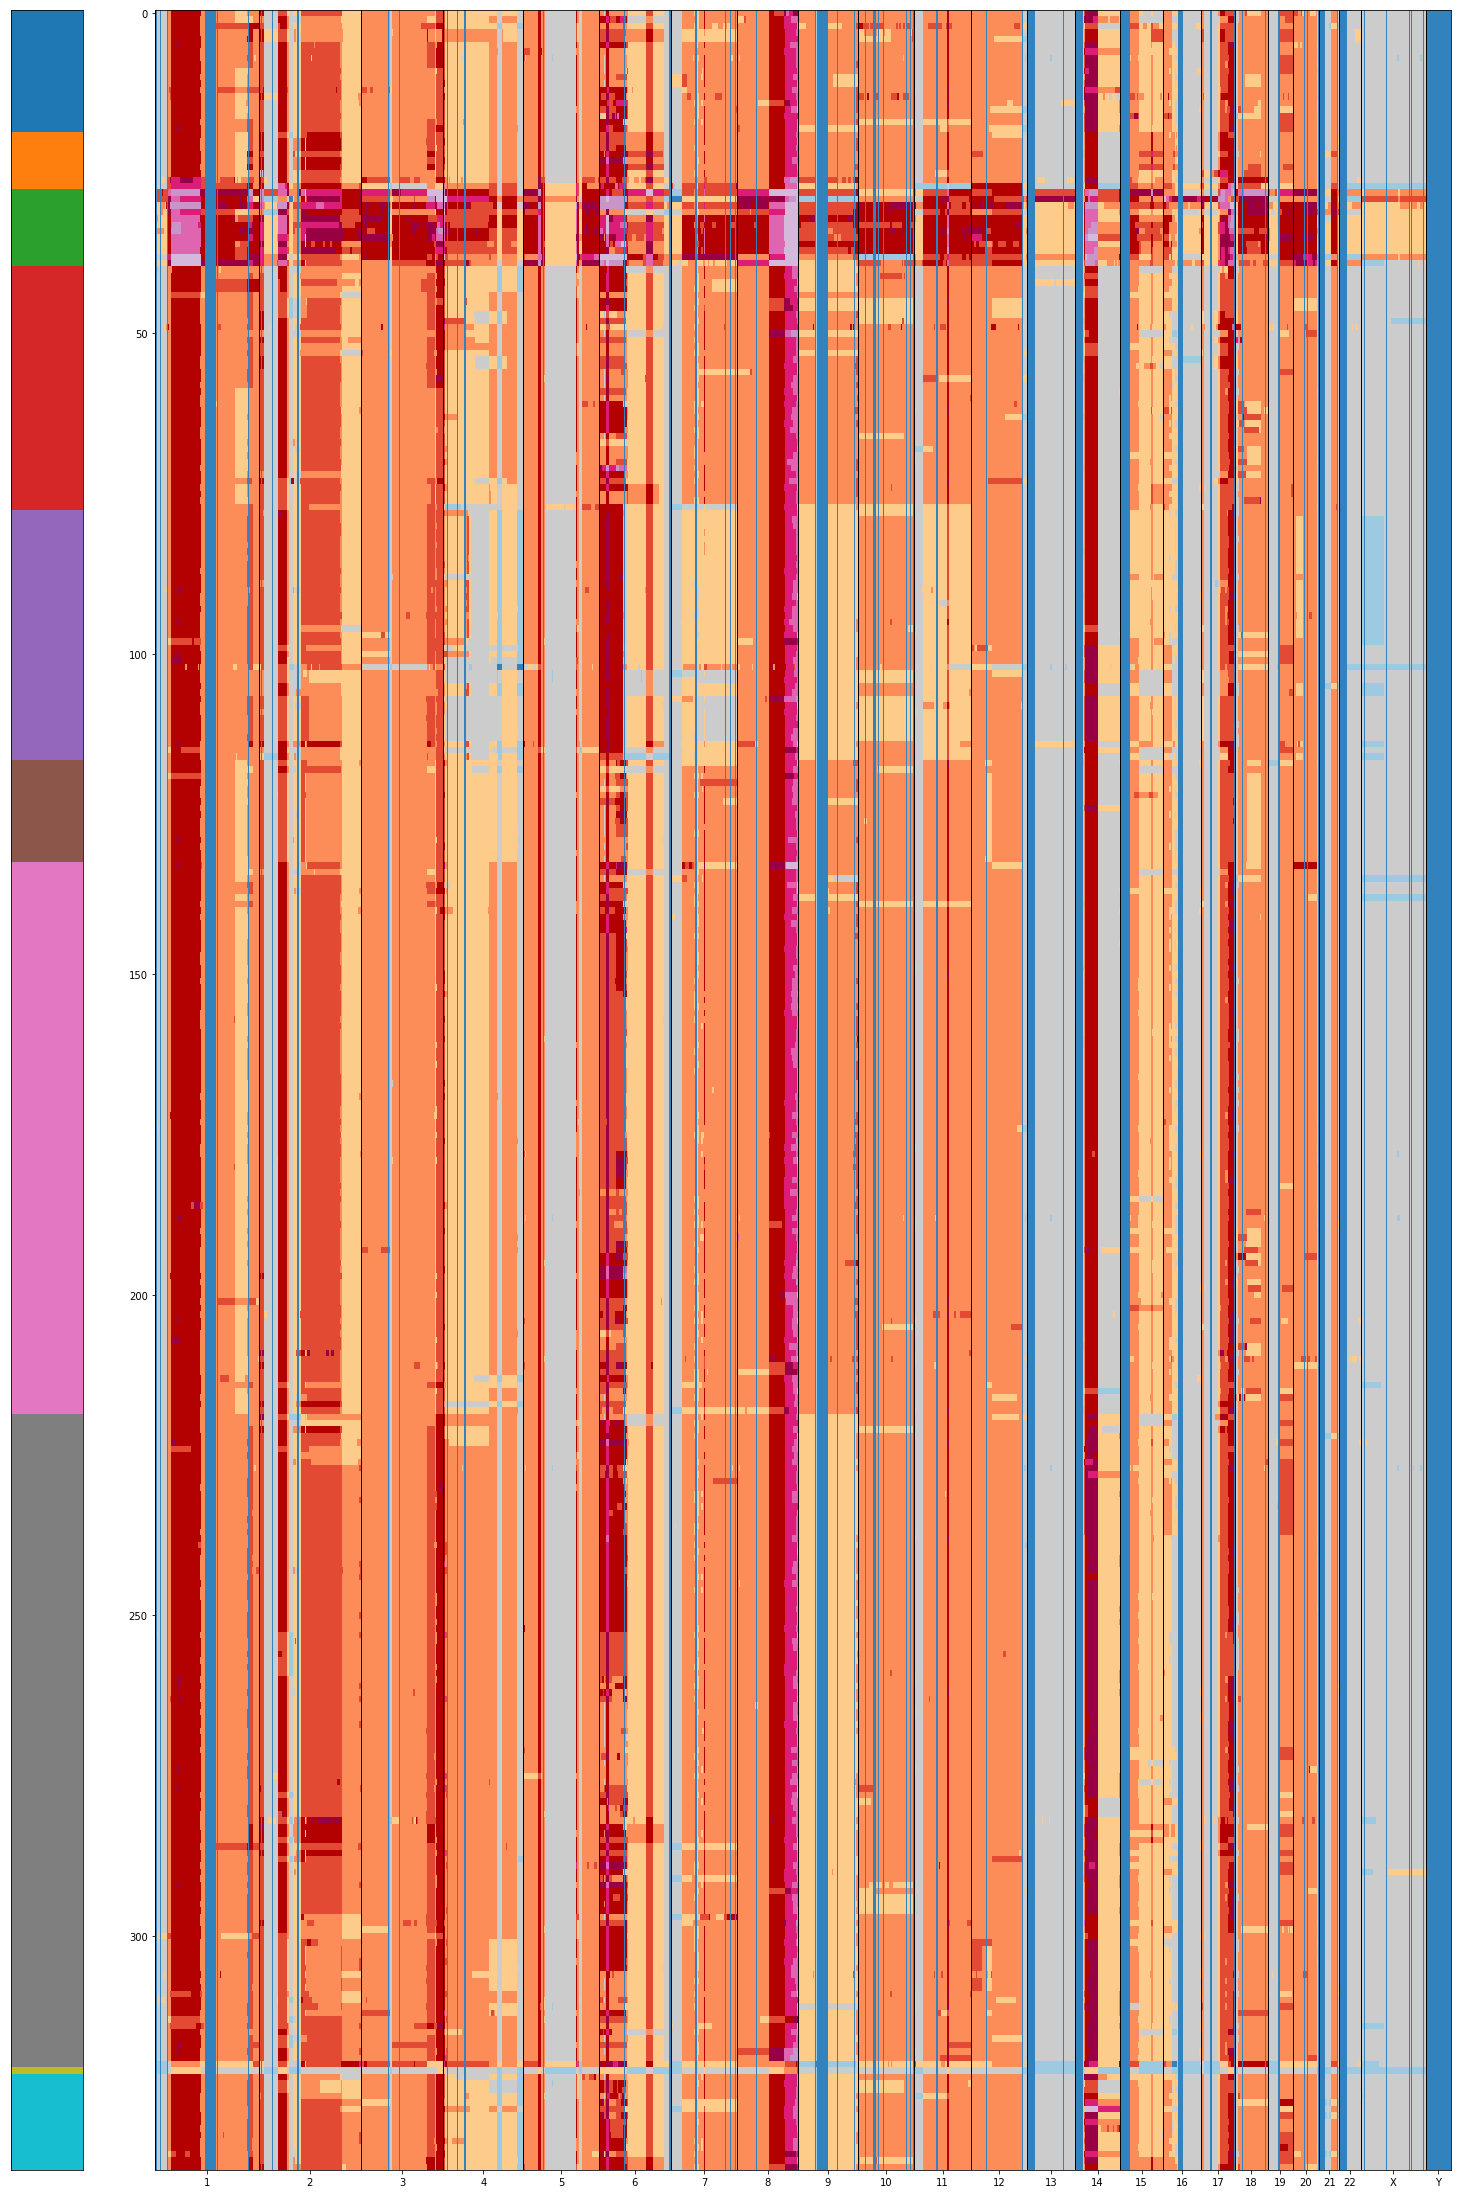

In [24]:

plot_data = cn_data.copy()
plot_data = plot_data.merge(gibbs_clusters)
bin_filter = (plot_data['gc'] <= 0) | (plot_data['copy'].isnull())
plot_data.loc[bin_filter, 'state'] = 0
plot_data.loc[plot_data['copy'] > 5, 'copy'] = 5.
plot_data.loc[plot_data['copy'] < 0, 'copy'] = 0.

cluster_col = 'gibbs_cluster_id'

fig = plt.figure(figsize=(15, 2))
scgenome.cnplot.plot_cluster_cn_matrix(
    fig, plot_data, 'state', cluster_field_name=cluster_col)

fig = plt.figure(figsize=(20, 30))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'copy', cluster_field_name=cluster_col, raw=True)

fig = plt.figure(figsize=(20, 30))
matrix_data = scgenome.cnplot.plot_clustered_cell_cn_matrix_figure(
    fig, plot_data, 'state', cluster_field_name=cluster_col)
